Dynamic triple determination for "pairs trading"

In [66]:
# Historical snapshot of coins from December 01, 2019: https://coinmarketcap.com/historical/20191201/ used to
# get a representative set of coins from before the period of analysis to avoid look-ahead bias.

strat_univ = [
    'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT',
    'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LINKUSDT', 'ATOMUSDT',
    'NEOUSDT', 'MKRUSDT', 'DASHUSDT', 'ETCUSDT', 'USDCUSDT', 'ONTUSDT', 'VETUSDT',
    'DOGEUSDT', 'BATUSDT', 'ZECUSDT',
    'SNXUSDT', 'QTUMUSDT', 'TUSDUSDT', 'ZRXUSDT',
    'THXUSDT', 'THRUSDT', 'ALGOUSDT', 'REPUSDT', 'NANOUSDT', 'KBCUSDT', 'BTGUSDT', 'RVNUSDT', 'OMGUSDT',
    'CNXUSDT', 'ABBCUSDT', 'XINUSDT', 'VSYSUSDT', 'SEELEUSDT', 'EONUSDT', 'ZBUSDT', 'EKTUSDT', 'DGBUSDT',
    'BTMUSDT', 'LSKUSDT', 'KMDUSDT', 'SAIUSDT', 'LUNAUSDT', 'KCSUSDT', 'FTTUSDT', 'QNTUSDT', 'SXPUSDT',
    'BDXUSDT', 'GAPUSDT', 'BCDUSDT', 'THETAUSDT', 'ICXUSDT', 'FSTUSDT', 'MATICUSDT', 'SCUSDT', 'EVRUSDT',
    'BTTUSDT', 'MOFUSDT', 'IOSTUSDT', 'MCOUSDT', 'WAVESUSDT', 'XVGUSDT', 'MONAUSDT', 'BTSUSDT', 'BCNUSDT',
    'HCUSDT', 'MAIDUSDT', 'NEXOUSDT', 'ARDRUSDT', 'DXUSDT', 'OKBUSDT', 'FXCUSDT', 'RLCUSDT', 'MBUSDT',
    'BXKUSDT', 'AEUSDT', 'ENJUSDT', 'STEEMUSDT', 'SLVUSDT', 'BRZEUSDT', 'ZILUSDT', 'VESTUSDT', 'ZENUSDT',
    'SOLVEUSDT', 'CHZUSDT', 'NOAHUSDT', 'LAUSDT', 'BTMXUSDT', 'ETNUSDT', 'ENGUSDT', 'ILCUSDT', 'NPXSUSDT',
    'CRPTUSDT', 'GNTUSDT', 'SNTUSDT', 'ELFUSDT', 'JWLUSDT', 'FETUSDT', 'BOTXUSDT', 'NRGUSDT', 'DGDUSDT',
    'EXMRUSDT', 'EURSUSDT', 'AOAUSDT', 'RIFUSDT', 'CIX100USDT', 'BFUSDT', 'XZCUSDT', 'FABUSDT', 'GRINUSDT',
    'NETUSDT', 'VERIUSDT', 'DGTXUSDT', 'KNCUSDT', 'RENUSDT', 'STRATUSDT', 'ETPUSDT', 'NEXUSDT', 'NEWUSDT',
    'BCZEROUSDT', 'GXCUSDT', 'TNTUSDT', 'BTC2USDT', 'PPTUSDT', 'USDKUSDT', 'ELAUSDT', 'IGNISUSDT', 'PLCUSDT',
    'BNKUSDT', 'DTRUSDT', 'RCNUSDT', 'HPTUSDT', 'LAMBUSDT', 'MANAUSDT', 'EDCUSDT', 'BEAMUSDT', 'TTUSDT',
    'AIONUSDT', 'BZUSDT', 'WTCUSDT', 'WICCUSDT', 'LRCUSDT', 'BRDUSDT', 'FCTUSDT', 'NULSUSDT', 'FTMUSDT',
    'IOTXUSDT', 'QBITUSDT', 'XMXUSDT', 'YOUUSDT', 'NASUSDT', 'WAXPUSDT', 'ARKUSDT', 'RDDUSDT', 'GNYUSDT',
    'AGVCUSDT', 'HYNUSDT', 'CVCUSDT', 'WANUSDT', 'WINUSDT', 'LINAUSDT', 'RUSDT', 'PAIUSDT', 'FSNUSDT',
    'FUNUSDT', 'DPTUSDT', 'BHDUSDT', 'LOOMUSDT', 'XACUSDT', 'BUSDUSDT', 'BHPUSDT', 'TRUEUSDT', 'LOKIUSDT',
    'QASHUSDT', 'BNTUSDT', 'DOTUSDT', 'SOLUSDT']

## Load And Structure Data

In [67]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

In [130]:
data_freq = '4h'
look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
in_sample_end = pd.to_datetime("2022-12-31 20:00:00")
out_sample_start = pd.to_datetime("2023-01-01 00:00:00")

In [131]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for XRPUSDT.
Downloaded data for BCHUSDT.
Downloaded data for LTCUSDT.
Downloaded data for EOSUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XLMUSDT.
Downloaded data for TRXUSDT.
Downloaded data for ADAUSDT.
Downloaded data for XTZUSDT.
Downloaded data for LINKUSDT.
Downloaded data for ATOMUSDT.
Downloaded data for NEOUSDT.
Downloaded data for MKRUSDT.
Downloaded data for DASHUSDT.
Downloaded data for ETCUSDT.
Downloaded data for USDCUSDT.
Downloaded data for ONTUSDT.
Downloaded data for VETUSDT.
Downloaded data for DOGEUSDT.
Downloaded data for BATUSDT.
Downloaded data for ZECUSDT.
Downloaded data for SNXUSDT.
Downloaded data for QTUMUSDT.
Downloaded data for TUSDUSDT.
Downloaded data for ZRXUSDT.
Couldn't load data for THXUSDT.
Couldn't load data for THRUSDT.
Downloaded data for ALGOUSDT.
Couldn't load data for REPUSDT.
Couldn't load data for NANOUSDT.
Couldn't load data for KBCUSDT.
Couldn't load data 

In [132]:
px_close = {coin: px_data[coin]["close"] for coin in px_data}
px_close = pd.DataFrame(px_close).astype(float)
px_close.index.rename("datetime", inplace=True)
# px_data

px_close

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,7230.71,130.18,0.19406,205.64,41.58,NaN,13.8159,0.04515,NaN,0.03308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,7205.50,130.52,0.19518,206.72,41.55,NaN,13.7648,0.04493,NaN,0.03320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,7195.80,130.84,0.19358,205.61,41.67,NaN,13.7162,0.04509,NaN,0.03321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,7233.02,131.84,0.19428,206.63,41.89,NaN,13.7958,0.04542,NaN,0.03357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,7223.72,131.98,0.19474,206.35,41.79,NaN,13.7270,0.04547,NaN,0.03361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-25 16:00:00,104963.40,3338.71,3.12530,452.20,127.23,0.8031,687.1000,0.41930,NaN,0.98420,...,0.4756,0.1630,0.5320,0.03839,0.03903,0.05737,NaN,0.667,6.375,258.34
2025-01-25 20:00:00,104734.79,3317.07,3.10830,440.50,123.95,0.8068,686.0300,0.41680,NaN,0.97730,...,0.4723,0.1654,0.5301,0.03839,0.03902,0.05959,NaN,0.667,6.324,255.87
2025-01-26 00:00:00,105032.90,3341.47,3.13240,445.80,124.16,0.7786,688.6300,0.42130,NaN,0.98480,...,0.4783,0.1667,0.5369,0.03693,0.03903,0.05959,NaN,0.667,6.336,258.56


## Determine Dynamic Triples Of Correlated Coins

In [133]:
# dynamic_triples = {px_close.index[0]: []}

# for index_pos in range(1, px_close.shape[0]+1):
#     available_coins = get_available_coins(dynamic_triplesindex_pos, px_close)

coins = px_close.iloc[50].sort_values(ascending=False)[:8].index
coins

Index(['BTCUSDT', 'BCHUSDT', 'ETHUSDT', 'LTCUSDT', 'BNBUSDT', 'NEOUSDT',
       'ETCUSDT', 'ATOMUSDT'],
      dtype='object')

In [210]:
# # SOLUSDT, DOTUSDT

# all_coins = list(coins) + ['SOLUSDT', 'DOTUSDT']
# all_coins

u = px_close.corr()['BTCUSDT']
all_coins = list(u[u > 0.8].index)
all_coins

['BTCUSDT',
 'ETHUSDT',
 'BNBUSDT',
 'LINKUSDT',
 'WAVESUSDT',
 'FETUSDT',
 'SOLUSDT']

In [211]:
px_close[all_coins]

,BTCUSDT,ETHUSDT,BNBUSDT,LINKUSDT,WAVESUSDT,FETUSDT,SOLUSDT
datetime,,,,,,,
2020-01-01 00:00:00,7230.71,130.18,13.8159,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,7205.50,130.52,13.7648,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,7195.80,130.84,13.7162,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,7233.02,131.84,13.7958,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,7223.72,131.98,13.7270,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-01-25 16:00:00,104963.40,3338.71,687.1000,25.19,NaN,1.200,258.34
2025-01-25 20:00:00,104734.79,3317.07,686.0300,24.93,NaN,1.211,255.87
2025-01-26 00:00:00,105032.90,3341.47,688.6300,25.60,NaN,1.215,258.56


In [212]:
independent_coins = all_coins[:]
independent_coins.remove('BTCUSDT')
independent_coins

['ETHUSDT', 'BNBUSDT', 'LINKUSDT', 'WAVESUSDT', 'FETUSDT', 'SOLUSDT']

In [213]:
independent_data = px_close[independent_coins][:]
independent_data

,ETHUSDT,BNBUSDT,LINKUSDT,WAVESUSDT,FETUSDT,SOLUSDT
datetime,,,,,,
2020-01-01 00:00:00,130.18,13.8159,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,130.52,13.7648,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,130.84,13.7162,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,131.84,13.7958,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,131.98,13.7270,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-01-25 16:00:00,3338.71,687.1000,25.19,NaN,1.200,258.34
2025-01-25 20:00:00,3317.07,686.0300,24.93,NaN,1.211,255.87
2025-01-26 00:00:00,3341.47,688.6300,25.60,NaN,1.215,258.56


In [308]:
independent_data_with_zeroes = independent_data.fillna(0.0)
independent_data_with_zeroes

,ETHUSDT,BNBUSDT,LINKUSDT,WAVESUSDT,FETUSDT,SOLUSDT
datetime,,,,,,
2020-01-01 00:00:00,130.18,13.8159,0.00,0.0,0.000,0.00
2020-01-01 04:00:00,130.52,13.7648,0.00,0.0,0.000,0.00
2020-01-01 08:00:00,130.84,13.7162,0.00,0.0,0.000,0.00
2020-01-01 12:00:00,131.84,13.7958,0.00,0.0,0.000,0.00
2020-01-01 16:00:00,131.98,13.7270,0.00,0.0,0.000,0.00
...,...,...,...,...,...,...
2025-01-25 16:00:00,3338.71,687.1000,25.19,0.0,1.200,258.34
2025-01-25 20:00:00,3317.07,686.0300,24.93,0.0,1.211,255.87
2025-01-26 00:00:00,3341.47,688.6300,25.60,0.0,1.215,258.56


In [309]:
import statsmodels.api as sm

independent_data_with_zeroes = sm.add_constant(independent_data_with_zeroes)

In [310]:
independent_data.corrwith(px_close["BTCUSDT"])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


ETHUSDT      0.846885
BNBUSDT      0.882304
LINKUSDT     0.816494
WAVESUSDT    0.867625
FETUSDT      0.828623
SOLUSDT      0.846466
dtype: float64

In [311]:
independent_data_with_zeroes

,const,ETHUSDT,BNBUSDT,LINKUSDT,WAVESUSDT,FETUSDT,SOLUSDT
datetime,,,,,,,
2020-01-01 00:00:00,1.0,130.18,13.8159,0.00,0.0,0.000,0.00
2020-01-01 04:00:00,1.0,130.52,13.7648,0.00,0.0,0.000,0.00
2020-01-01 08:00:00,1.0,130.84,13.7162,0.00,0.0,0.000,0.00
2020-01-01 12:00:00,1.0,131.84,13.7958,0.00,0.0,0.000,0.00
2020-01-01 16:00:00,1.0,131.98,13.7270,0.00,0.0,0.000,0.00
...,...,...,...,...,...,...,...
2025-01-25 16:00:00,1.0,3338.71,687.1000,25.19,0.0,1.200,258.34
2025-01-25 20:00:00,1.0,3317.07,686.0300,24.93,0.0,1.211,255.87
2025-01-26 00:00:00,1.0,3341.47,688.6300,25.60,0.0,1.215,258.56


In [312]:
px_close["BTCUSDT"]

datetime
2020-01-01 00:00:00      7230.71
2020-01-01 04:00:00      7205.50
2020-01-01 08:00:00      7195.80
2020-01-01 12:00:00      7233.02
2020-01-01 16:00:00      7223.72
                         ...    
2025-01-25 16:00:00    104963.40
2025-01-25 20:00:00    104734.79
2025-01-26 00:00:00    105032.90
2025-01-26 04:00:00    104970.51
2025-01-26 08:00:00    104747.62
Name: BTCUSDT, Length: 11109, dtype: float64

In [317]:
independent_data_with_zeroes[independent_data_with_zeroes.isna()].iloc[8]

const       NaN
ETHUSDT     NaN
BNBUSDT     NaN
LINKUSDT    NaN
WAVESUSDT   NaN
FETUSDT     NaN
SOLUSDT     NaN
Name: 2020-01-02 08:00:00, dtype: float64

In [313]:
from statsmodels.regression.rolling import RollingOLS

model = RollingOLS(px_close["BTCUSDT"], independent_data_with_zeroes, window=look_back_window_size,
                   min_nobs=look_back_min_periods, expanding=True)
rolling_result = model.fit(params_only=True)
rolling_result.params

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,const,ETHUSDT,BNBUSDT,LINKUSDT,WAVESUSDT,FETUSDT,SOLUSDT
datetime,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-01-25 16:00:00,45097.402049,-11.090675,54.732728,1156.468686,34346.478559,6730.629369,81.830702
2025-01-25 20:00:00,45204.581848,-10.993599,54.323487,1154.125694,34317.071619,6610.181076,82.162963
2025-01-26 00:00:00,45107.292138,-10.979044,54.432041,1150.706413,34321.469957,6588.400331,82.533407


In [314]:
rolling_result.params.loc["2020-06-01"]

,const,ETHUSDT,BNBUSDT,LINKUSDT,WAVESUSDT,FETUSDT,SOLUSDT
datetime,,,,,,,
2020-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [294]:
independent_data_with_zeroes.loc["2020-06-01"]

,const,ETHUSDT,BNBUSDT,LINKUSDT,WAVESUSDT,FETUSDT,SOLUSDT
datetime,,,,,,,
2020-06-01 00:00:00,1.0,238.59,17.4501,0.0,0.0,0.0,0.0
2020-06-01 04:00:00,1.0,238.46,17.4515,0.0,0.0,0.0,0.0
2020-06-01 08:00:00,1.0,236.48,17.2824,0.0,0.0,0.0,0.0
2020-06-01 12:00:00,1.0,237.86,17.3292,0.0,0.0,0.0,0.0
2020-06-01 16:00:00,1.0,238.13,17.4351,0.0,0.0,0.0,0.0
2020-06-01 20:00:00,1.0,248.00,17.9038,0.0,0.0,0.0,0.0


In [222]:
estimates = (rolling_result.params[independent_coins] * px_close[independent_coins]).sum(axis=1) + rolling_result.params["const"]
estimates

datetime
2020-01-01 00:00:00              NaN
2020-01-01 04:00:00              NaN
2020-01-01 08:00:00              NaN
2020-01-01 12:00:00              NaN
2020-01-01 16:00:00              NaN
                           ...      
2025-01-25 16:00:00    104024.055437
2025-01-25 20:00:00    103805.905937
2025-01-26 00:00:00    104707.510682
2025-01-26 04:00:00    104828.503519
2025-01-26 08:00:00              NaN
Length: 11109, dtype: float64

<Axes: xlabel='datetime'>

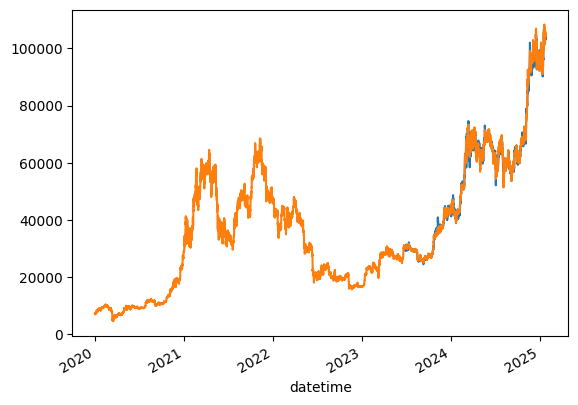

In [223]:
estimates.plot()
px_close["BTCUSDT"].plot()

In [224]:
residuals = px_close["BTCUSDT"] - estimates
residuals

datetime
2020-01-01 00:00:00           NaN
2020-01-01 04:00:00           NaN
2020-01-01 08:00:00           NaN
2020-01-01 12:00:00           NaN
2020-01-01 16:00:00           NaN
                          ...    
2025-01-25 16:00:00    939.344563
2025-01-25 20:00:00    928.884063
2025-01-26 00:00:00    325.389318
2025-01-26 04:00:00    142.006481
2025-01-26 08:00:00           NaN
Length: 11109, dtype: float64

In [225]:
spread_data = {"residuals": residuals}

rolling_mean = residuals.rolling(window=look_back_window_size, min_periods=look_back_min_periods).mean()
spread_data["rolling mean"] = rolling_mean
rolling_mean

datetime
2020-01-01 00:00:00           NaN
2020-01-01 04:00:00           NaN
2020-01-01 08:00:00           NaN
2020-01-01 12:00:00           NaN
2020-01-01 16:00:00           NaN
                          ...    
2025-01-25 16:00:00    440.199382
2025-01-25 20:00:00    445.652527
2025-01-26 00:00:00    448.956479
2025-01-26 04:00:00    453.249195
2025-01-26 08:00:00    453.709471
Length: 11109, dtype: float64

In [226]:
rolling_std = residuals.rolling(window=look_back_window_size, min_periods=look_back_min_periods).std()
spread_data["rolling_std"] = rolling_std
rolling_std

datetime
2020-01-01 00:00:00            NaN
2020-01-01 04:00:00            NaN
2020-01-01 08:00:00            NaN
2020-01-01 12:00:00            NaN
2020-01-01 16:00:00            NaN
                          ...     
2025-01-25 16:00:00    1605.858239
2025-01-25 20:00:00    1605.841763
2025-01-26 00:00:00    1604.974077
2025-01-26 04:00:00    1603.102546
2025-01-26 08:00:00    1607.587409
Length: 11109, dtype: float64

In [227]:
z_scores = (residuals - rolling_mean) / rolling_std
spread_data["z_scores"] = z_scores
z_scores

datetime
2020-01-01 00:00:00         NaN
2020-01-01 04:00:00         NaN
2020-01-01 08:00:00         NaN
2020-01-01 12:00:00         NaN
2020-01-01 16:00:00         NaN
                         ...   
2025-01-25 16:00:00    0.310828
2025-01-25 20:00:00    0.300921
2025-01-26 00:00:00   -0.076990
2025-01-26 04:00:00   -0.194150
2025-01-26 08:00:00         NaN
Length: 11109, dtype: float64

In [287]:
# z_scores[z_scores.notna()]
# residuals[residuals.notna()]
estimates[estimates.notna()]

datetime
2023-06-27 00:00:00     30368.120000
2023-06-27 04:00:00     30325.742595
2023-06-27 08:00:00     30660.590089
2023-06-27 12:00:00     30667.391565
2023-06-27 16:00:00     30866.895171
                           ...      
2025-01-25 12:00:00    103552.579728
2025-01-25 16:00:00    104024.055437
2025-01-25 20:00:00    103805.905937
2025-01-26 00:00:00    104707.510682
2025-01-26 04:00:00    104828.503519
Length: 3476, dtype: float64

In [228]:
spread_data = pd.DataFrame(spread_data)
spread_data

,residuals,rolling mean,rolling_std,z_scores
datetime,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,NaN,NaN,NaN,NaN
2020-01-01 08:00:00,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2025-01-25 16:00:00,939.344563,440.199382,1605.858239,0.310828
2025-01-25 20:00:00,928.884063,445.652527,1605.841763,0.300921
2025-01-26 00:00:00,325.389318,448.956479,1604.974077,-0.076990


In [229]:
z_scores[z_scores.abs() > 1.0]

datetime
2023-07-07 00:00:00    1.280800
2023-07-10 08:00:00    1.142052
2023-07-10 12:00:00    1.308223
2023-07-10 16:00:00    1.303928
2023-07-10 20:00:00    1.100567
                         ...   
2025-01-22 12:00:00   -1.183395
2025-01-22 16:00:00   -1.626491
2025-01-22 20:00:00   -1.564860
2025-01-23 00:00:00   -1.651717
2025-01-23 08:00:00   -1.081489
Length: 1234, dtype: float64

In [236]:
threshold = 1.0

def get_holdings_for_strategy_A(px_close, threshold, z_scores, independent_coins, rolling_result):
    holdings_df = pd.DataFrame(0.0, columns=px_close.columns, index=px_close.index)

    hi_z_scores = z_scores[z_scores > threshold]
    lo_z_scores = z_scores[z_scores < -threshold]

    holdings_df.loc[hi_z_scores.index, "BTCUSDT"] = -1.0
    holdings_df.loc[hi_z_scores.index, independent_coins] = rolling_result.params.loc[hi_z_scores.index, independent_coins]

    holdings_df.loc[lo_z_scores.index, "BTCUSDT"] = 1.0
    holdings_df.loc[lo_z_scores.index, independent_coins] = -rolling_result.params.loc[lo_z_scores.index, independent_coins]

    holdings_df = holdings_df.shift()
    holdings_df = holdings_df.divide(holdings_df.abs().sum(axis=1), axis=0)
    holdings_df.fillna(0.0, inplace=True)
    return holdings_df

holdings_df_A = get_holdings_for_strategy_A(px_close, threshold, z_scores, independent_coins, rolling_result)
holdings_df_A

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-25 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-25 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-26 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [237]:
rolling_result.params.loc[z_scores[z_scores > 1.0].index, independent_coins]

,ETHUSDT,BNBUSDT,LINKUSDT,WAVESUSDT,FETUSDT,SOLUSDT
datetime,,,,,,
2023-07-07 00:00:00,16.260271,-76.556501,-785.719533,391.002047,52065.722473,-185.166651
2023-07-10 08:00:00,7.781869,-45.365104,-625.767915,187.718076,67953.108928,129.458315
2023-07-10 12:00:00,8.128459,-44.032134,-634.175741,193.353383,66138.840093,132.109282
2023-07-10 16:00:00,8.541888,-42.865977,-634.183482,192.619123,63998.800811,135.605825
2023-07-10 20:00:00,8.910074,-41.781418,-616.300857,186.373196,61773.123830,139.076433
...,...,...,...,...,...,...
2025-01-16 00:00:00,3.701943,-13.673001,640.171228,15352.108619,7759.900380,26.078355
2025-01-16 04:00:00,2.420611,-13.527396,683.109333,16693.878116,6537.505457,47.500888
2025-01-17 12:00:00,-5.327863,-14.004401,886.183094,34638.829212,1520.268551,148.018905


In [238]:
holdings_df_A.loc["2021-12-12"]

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2021-12-12 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-12 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-12 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-12 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-12 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-12 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [239]:
def get_net_return(strat_holdings, ret):
    # assume that strat_holdings have already been shifted back in time to avoid look-ahead bias.
    gross_ret = (strat_holdings * ret).sum(axis=1)
    
    turnover = (strat_holdings.fillna(0) - strat_holdings.shift().fillna(0)).abs().sum(axis=1)
    tcost_bps = 20
    return gross_ret.subtract(turnover * tcost_bps * 1e-4, fill_value=0)

<Axes: xlabel='datetime'>

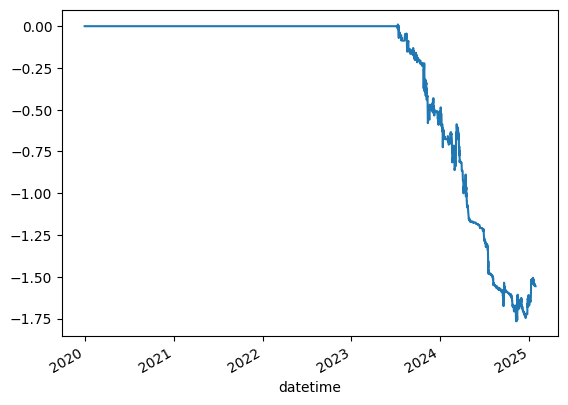

In [240]:
close_price_returns = px_close / px_close.shift() - 1
get_net_return(holdings_df_A, close_price_returns).cumsum().plot()

In [259]:
from enum import Enum
import math

threshold = 2.5

holdings_df_B = pd.DataFrame(0.0, columns=px_close.columns, index=px_close.index)

class ZScoreType(Enum):
    HI_Z_SCORE = 1
    LO_Z_SCORE = 2
    MID_Z_SCORE = 3

z_score_type = ZScoreType.MID_Z_SCORE
    
for datetime_point in px_close.index:
    curr_z_score = z_scores.loc[datetime_point]
    if not math.isnan(curr_z_score):
        if curr_z_score > threshold or (z_score_type == ZScoreType.HI_Z_SCORE and curr_z_score > 0.0):
            holdings_df_B.loc[datetime_point, "BTCUSDT"] = -1.0
            holdings_df_B.loc[datetime_point, independent_coins] = \
                rolling_result.params.loc[datetime_point, independent_coins]
            z_score_type = ZScoreType.HI_Z_SCORE
        elif curr_z_score < -threshold or (z_score_type == ZScoreType.LO_Z_SCORE and curr_z_score < 0.0):
            holdings_df_B.loc[datetime_point, "BTCUSDT"] = 1.0
            holdings_df_B.loc[datetime_point, independent_coins] = \
                -rolling_result.params.loc[datetime_point, independent_coins]
            z_score_type = ZScoreType.LO_Z_SCORE
        elif curr_z_score > 0.0 and z_score_type == ZScoreType.LO_Z_SCORE:
            z_score_type = ZScoreType.MID_Z_SCORE
        elif curr_z_score < 0.0 and z_score_type == ZScoreType.HI_Z_SCORE:
            z_score_type = ZScoreType.MID_Z_SCORE
        
holdings_df_B = holdings_df_B.divide(holdings_df_B.abs().sum(axis=1), axis=0)
holdings_df_B = holdings_df_B.shift()
holdings_df_B.fillna(0.0, inplace=True)

holdings_df_B[holdings_df_B["BTCUSDT"] > 0.0]

,BTCUSDT,ETHUSDT,XRPUSDT,BCHUSDT,LTCUSDT,EOSUSDT,BNBUSDT,XLMUSDT,TRXUSDT,ADAUSDT,...,MANAUSDT,LRCUSDT,FTMUSDT,IOTXUSDT,WAXPUSDT,LOOMUSDT,BUSDUSDT,BNTUSDT,DOTUSDT,SOLUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2023-09-23 20:00:00,0.000102,-0.001229,0.0,0.0,0.0,0.0,-0.004658,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030258
2023-09-24 00:00:00,0.000103,-0.001191,0.0,0.0,0.0,0.0,-0.005033,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029866
2023-09-24 04:00:00,0.000103,-0.001176,0.0,0.0,0.0,0.0,-0.005205,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029858
2023-09-24 08:00:00,0.000104,-0.001181,0.0,0.0,0.0,0.0,-0.005368,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030204
2023-09-24 12:00:00,0.000105,-0.001180,0.0,0.0,0.0,0.0,-0.005515,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 20:00:00,0.000085,-0.001488,0.0,0.0,0.0,0.0,-0.000164,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001100
2024-12-25 00:00:00,0.000065,-0.001195,0.0,0.0,0.0,0.0,-0.000034,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000203
2024-12-25 04:00:00,0.000063,-0.001227,0.0,0.0,0.0,0.0,0.000091,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000560


<Axes: xlabel='datetime'>

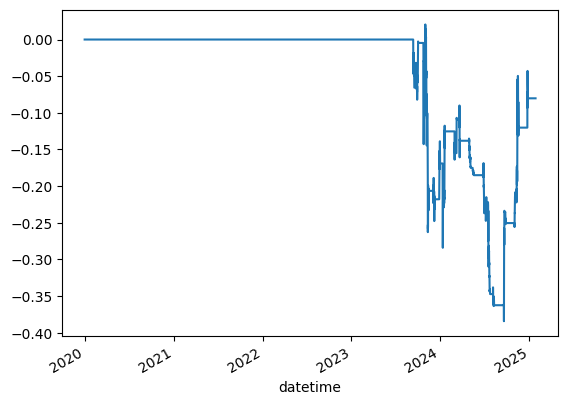

In [260]:
get_net_return(holdings_df_B, close_price_returns).cumsum().plot()